# Prophet on Total Sales (Units Sold) with Explanatory Variables

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import logging
%matplotlib inline

In [3]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [4]:
def calculate_mape(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred) * 100

In [5]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true)
    smape = np.mean(np.where(denominator == 0, 0, diff / denominator)) * 100
    return smape

In [29]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [30]:
total_df = df.groupby('Date')[['UnitsSold', 'PricePerUnitPounds']].sum().reset_index()
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [31]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')
explanatory_df

,date,gift_ideas,chained-volume-percentage-change-3-months-on-same-period-a-year-earlier,chained-volume-percentage-change-on-previous-month,chained-volume-percentage-change-on-same-month-a-year-earlier,current-prices-percentage-change-on-previous-month,current-prices-percentage-change-on-same-month-a-year-earlier,is_black_friday,is_cyber_monday,cpi,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2009-12-01,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
1,2009-12-02,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4532,7.7,0.0,False,False,False,False,False,False,True
2,2009-12-03,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4522,7.7,0.0,False,False,False,False,True,False,False
3,2009-12-04,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,True,False,False,False,False,False,False
4,2009-12-05,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2011-12-05,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5273,8.3,0.0,False,True,False,False,False,False,False
735,2011-12-06,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5272,8.3,0.0,False,False,False,False,False,True,False
736,2011-12-07,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5264,8.3,0.0,False,False,False,False,False,False,True
737,2011-12-08,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5392,8.3,0.0,False,False,False,False,True,False,False


In [32]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

In [33]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])
total_df.columns

Index(['ds', 'y', 'PricePerUnitPounds', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday'],
      dtype='object')

In [35]:
regressors = ['PricePerUnitPounds', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday']

In [38]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [39]:
model = Prophet()

for reg in regressors:
    model.add_regressor(reg)
    
model.fit(train_data)

19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [ ]:
validation_forecast = model.predict(validation_data)

In [ ]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

validation_mape = calculate_mape(actual_values, predicted_values)
validation_mape

30.777606948615666

In [ ]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

27.656392994751528

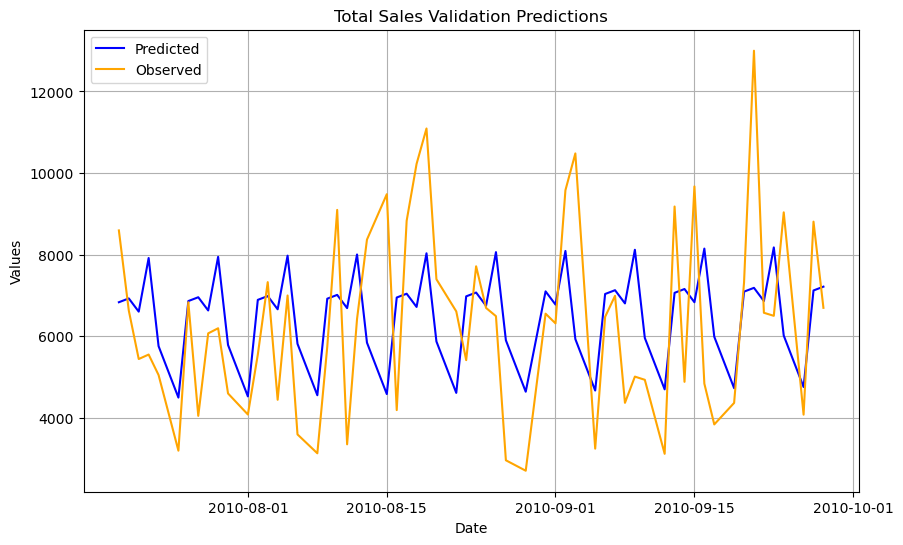

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [ ]:
test_forecast = model.predict(test_data)

In [ ]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

test_mape = calculate_mape(actual_values, predicted_values)
test_mape

25.333861192871375

In [ ]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

25.447573790449024

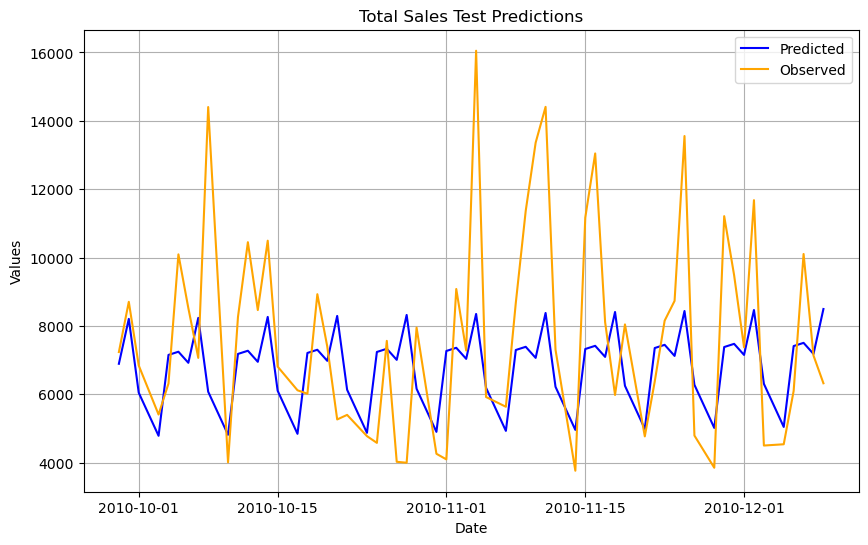

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

In [ ]:
validation_forecast = validation_forecast.sort_values('ds')
test_forecast = test_forecast.sort_values('ds')

In [ ]:
for df_ in [train_df, val_df, test_df, validation_forecast, test_forecast]:
    df_['ds'] = pd.to_datetime(df_['ds'], errors='coerce')

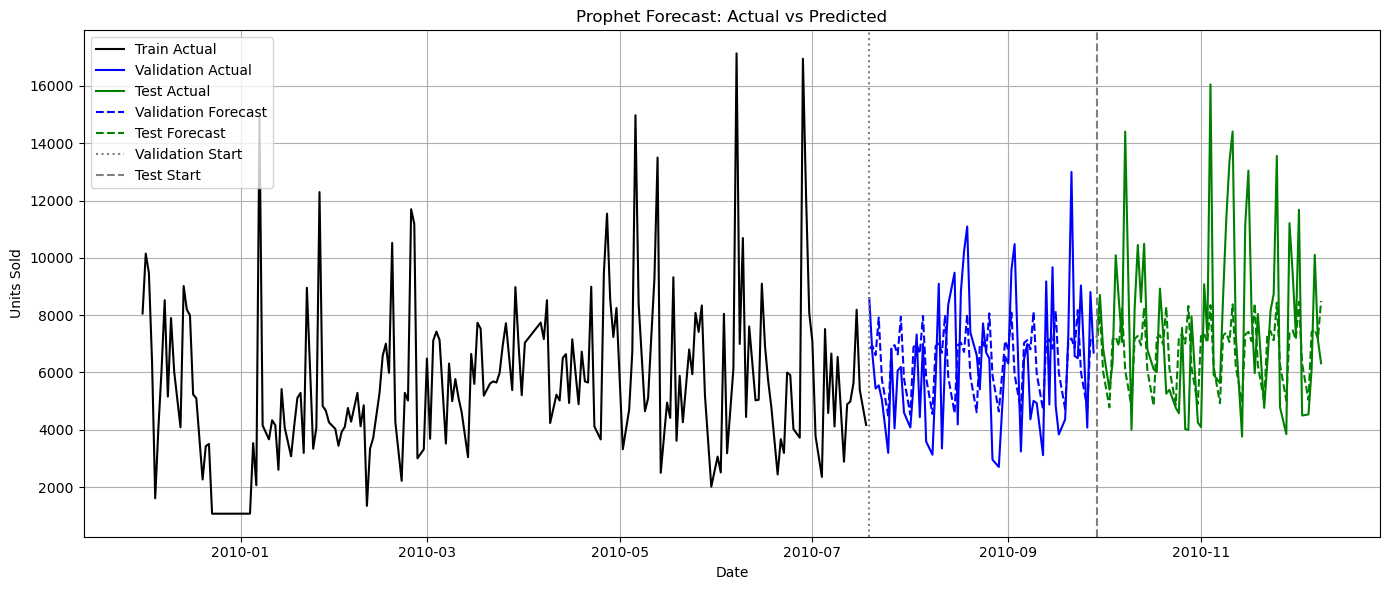

In [ ]:
plt.figure(figsize=(14, 6))

plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black')
plt.plot(val_df['ds'], val_df['y'], label='Validation Actual', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=val_df['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_df['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
